<a href="https://www.kaggle.com/code/georgelukaanya/reportnotebook?scriptVersionId=229255991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
!pip install reportlab

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from pprint import pprint
from IPython.display import IFrame

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv
/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv


In [9]:
def load_data(file_path, index_col='created_at'):
    """
    Load data from a CSV file and set the specified column as the index.
    Convert the index to datetime and remove duplicate indices.
    """
    df = pd.read_csv(file_path, index_col=index_col)
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep='first')]  # Remove duplicate indices
    return df

def clean_humidity_data(df):
    """
    Clean the humidity data:
    - Replace '*2*' with a comma in the 'record' column.
    - Split the 'record' column into 'Interior (%)' and 'Exterior (%)'.
    - Convert new columns to numeric types.
    - Replace values of 2 with NaN.
    """
    df['record'] = df['record'].str.replace('*2*', ',', regex=False)
    df[['Interior (%)', 'Exterior (%)']] = df['record'].str.split(',', expand=True)
    df = df.drop(columns=['record'])
    df['Interior (%)'] = pd.to_numeric(df['Interior (%)'], errors='coerce')
    df['Exterior (%)'] = pd.to_numeric(df['Exterior (%)'], errors='coerce')
    df['Interior (%)'] = df['Interior (%)'].replace(2, np.nan)
    df['Exterior (%)'] = df['Exterior (%)'].replace(2, np.nan)
    return df

def clean_temperature_data(df):
    """
    Clean the temperature data:
    - Replace '*2*' with a comma in the 'record' column.
    - Split the 'record' column into 'Interior (°C)' and 'Exterior (°C)'.
    - Convert new columns to numeric types.
    - Replace values of 2 with NaN.
    """
    df['record'] = df['record'].str.replace('*2*', ',', regex=False)
    df[['Interior (°C)', 'Exterior (°C)']] = df['record'].str.split(',', expand=True)
    df = df.drop(columns=['record'])
    df['Interior (°C)'] = pd.to_numeric(df['Interior (°C)'], errors='coerce')
    df['Exterior (°C)'] = pd.to_numeric(df['Exterior (°C)'], errors='coerce')
    df['Interior (°C)'] = df['Interior (°C)'].replace(2, np.nan)
    df['Exterior (°C)'] = df['Exterior (°C)'].replace(2, np.nan)
    return df

def clean_numeric_column(df, column='record'):
    """
    Clean a numeric column by replacing specific values (e.g., 2) with NaN.
    """
    df[column] = df[column].replace(2, np.nan)
    return df

def remove_nan_values(df):
    """
    Remove rows with NaN values from the DataFrame.
    """
    return df.dropna()

In [10]:
# File paths
file_paths = {
    'carbondioxide': '/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_carbondioxide_APR_FEB_hive1.csv',
    'humidity': '/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_humidity_APR_FEB_hive1.csv',
    'temperatures': '/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_temperatures_APR_FEB_hive1.csv',
    'weights': '/kaggle/input/adamnea-monthly-data-apr2024-feb2025/hive_weights_APR_FEB_hive1.csv'
}

# Load data
carbondioxide = load_data(file_paths['carbondioxide'])
humidity = load_data(file_paths['humidity'])
temperatures = load_data(file_paths['temperatures'])
weights = load_data(file_paths['weights'])

# Clean data
humidity = clean_humidity_data(humidity)
temperatures = clean_temperature_data(temperatures)
carbondioxide = clean_numeric_column(carbondioxide)
weights = clean_numeric_column(weights)

# Remove NaN values
carbondioxide = remove_nan_values(carbondioxide)
humidity = remove_nan_values(humidity)
temperatures = remove_nan_values(temperatures)
weights = remove_nan_values(weights)

In [11]:
# Display the first few rows of each cleaned DataFrame
print("Carbondioxide Data:")
print(carbondioxide.head())

print("\nHumidity Data:")
print(humidity.head())

print("\nTemperatures Data:")
print(temperatures.head())

print("\nWeights Data:")
print(weights.head())

Carbondioxide Data:
                     record
created_at                 
2024-04-03 17:08:06  7330.0
2024-04-03 23:10:57  6237.0
2024-04-04 05:13:54  1475.0
2024-04-04 11:17:07   195.0
2024-04-16 15:14:21   231.0

Humidity Data:
                     Interior (%)  Exterior (%)
created_at                                     
2024-04-03 17:08:06          94.2          84.3
2024-04-03 23:10:57          93.2          91.9
2024-04-04 05:13:54          98.4          86.6
2024-04-04 11:17:07          88.6          70.6
2024-04-30 15:28:14          89.7          78.3

Temperatures Data:
                     Interior (°C)  Exterior (°C)
created_at                                       
2024-04-03 17:08:06           27.3           23.9
2024-04-03 23:10:57           23.7           21.2
2024-04-04 05:13:54           25.3           22.2
2024-04-04 11:17:07           29.5           28.6
2024-04-30 15:28:14           28.1           25.6

Weights Data:
                     record
created_at         

In [30]:
def prepare_data(df):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

def filter_data_by_month_year(df, year, month):
    return df[(df['year'] == year) & (df['month'] == month)]

def calculate_basic_statistics(df_filtered):
    mean_co2 = round(df_filtered['record'].mean(), 2)
    median_co2 = round(df_filtered['record'].median(), 2)
    std_co2 = round(df_filtered['record'].std(), 2)
    min_co2 = round(df_filtered['record'].min(), 2)
    max_co2 = round(df_filtered['record'].max(), 2)
    return {
        "Mean CO2": mean_co2,
        "Median CO2": median_co2,
        "Standard Deviation": std_co2,
        "Min CO2": min_co2,
        "Max CO2": max_co2
    }

def calculate_diurnal_variation(df_filtered):
    day_records = df_filtered.between_time("07:00", "18:59")
    night_records = df_filtered.between_time("19:00", "06:59")
    day_mean = round(day_records['record'].mean(), 2) if not day_records.empty else None
    night_mean = round(night_records['record'].mean(), 2) if not night_records.empty else None
    day_variability = round(day_records['record'].std(), 2) if not day_records.empty else None
    night_variability = round(night_records['record'].std(), 2) if not night_records.empty else None
    return {
        "Daytime Mean CO2": day_mean,
        "Nighttime Mean CO2": night_mean,
        "Daytime Variability": day_variability,
        "Nighttime Variability": night_variability
    }

def calculate_weekly_trend(df_filtered):
    return df_filtered.resample('W')['record'].mean().round(2).to_dict()

def calculate_daily_trend(df_filtered):
    return df_filtered.resample('D')['record'].mean().round(2).to_dict()

def detect_anomalies(df_filtered, mean_co2, std_co2):
    df_filtered = df_filtered.assign(z_score=(df_filtered['record'] - mean_co2) / std_co2)
    anomalies = df_filtered[pd.notna(df_filtered['z_score']) & (np.abs(df_filtered['z_score']) > 2)]
    return anomalies[['record']].to_dict(orient='records')

def format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies):
    return {
        "Year": year,
        "Month": month,
        "Statistics": statistics,
        "Diurnal Variations": diurnal_variation,
        "Trends": {
            "Weekly Trend": weekly_trend,
            "Daily Trend": daily_trend
        },
        "Anomalies": anomalies
    }

def plot_monthly_trend(df_filtered, filename):
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered['record'], color='b', linestyle='-', marker='o', markersize=4)
    plt.title("CO2 Levels Over the Month", fontsize=16, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("CO2 (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def plot_diurnal_variation(df_filtered, filename):
    df_filtered = df_filtered.assign(period=['Day' if 7 <= x.hour < 19 else 'Night' for x in df_filtered.index])
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='period', y='record', data=df_filtered, palette="coolwarm")
    plt.title("Diurnal Variation of CO2 Levels", fontsize=16, weight='bold')
    plt.xlabel("Period", fontsize=12)
    plt.ylabel("CO2 Levels (ppm)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename)  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def analyze_co2_pipeline(df, year, month):
    df = prepare_data(df)
    df_filtered = filter_data_by_month_year(df, year, month)
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    statistics = calculate_basic_statistics(df_filtered)
    diurnal_variation = calculate_diurnal_variation(df_filtered)
    weekly_trend = calculate_weekly_trend(df_filtered)
    daily_trend = calculate_daily_trend(df_filtered)
    anomalies = detect_anomalies(df_filtered, statistics["Mean CO2"], statistics["Standard Deviation"])
    
    # Save and display plots
    plot_monthly_trend(df_filtered, "co2_monthly_trend.png")
    plot_diurnal_variation(df_filtered, "co2_diurnal_variation.png")
    
    return format_results(year, month, statistics, diurnal_variation, weekly_trend, daily_trend, anomalies)

In [22]:
def analyze_weight_for_month_year(df, year, month):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df_filtered = df[(df['year'] == year) & (df['month'] == month)]
    
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot monthly trend
    plt.figure(figsize=(12, 6))
    df_filtered['record'].plot(title=f"Weight Trend for {year}-{month:02d}", xlabel="Date", ylabel="Weight (kgs)", color='b', linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("weight_monthly_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    mean_weight = round(df_filtered['record'].mean(), 2)
    max_weight = round(df_filtered['record'].max(), 2)
    min_weight = round(df_filtered['record'].min(), 2)
    
    # Daily fluctuations
    daily_fluctuations = df_filtered.resample('D')['record'].agg(['min', 'max', 'mean'])
    daily_fluctuations['fluctuation_range'] = daily_fluctuations['max'] - daily_fluctuations['min']
    significant_fluctuations = daily_fluctuations[daily_fluctuations['fluctuation_range'] > 1]
    
    # Hourly patterns
    hourly_trend = df_filtered.resample('h')['record'].mean()  # Fix: Use 'h' instead of 'H'
    daytime_weight = hourly_trend.between_time("06:00", "17:59")
    nighttime_weight = hourly_trend.between_time("18:00", "05:59")
    day_mean_weight = round(daytime_weight.mean(), 2)
    night_mean_weight = round(nighttime_weight.mean(), 2)
    
    return {
        "Year": year,
        "Month": month,
        "Statistics": {
            "Maximum Weight": max_weight,
            "Minimum Weight": min_weight,
            "Mean Weight": mean_weight
        },
        "Daily Weight Fluctuations": significant_fluctuations.to_dict(orient='records'),
        "Hourly Patterns": {
            "Daytime Mean Weight": day_mean_weight,
            "Nighttime Mean Weight": night_mean_weight
        }
    }

In [23]:
def analyze_temperature_for_month_year(df, year, month):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df_filtered = df[(df['year'] == year) & (df['month'] == month)]
    
    if df_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot temperature trends
    plt.figure(figsize=(12, 6))
    df_filtered[['Interior (°C)', 'Exterior (°C)']].plot(title=f"Temperature Trend for {year}-{month:02d}", xlabel="Date", ylabel="Temperature (°C)", color=['r', 'b'], linestyle='-', marker='o', markersize=4)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("temperature_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    avg_ext_temp = round(df_filtered['Exterior (°C)'].mean(), 1)
    max_ext_temp = round(df_filtered['Exterior (°C)'].max(), 1)
    min_ext_temp = round(df_filtered['Exterior (°C)'].min(), 1)
    avg_int_temp = round(df_filtered['Interior (°C)'].mean(), 1)
    max_int_temp = round(df_filtered['Interior (°C)'].max(), 1)
    min_int_temp = round(df_filtered['Interior (°C)'].min(), 1)
    
    # Standard deviation
    ext_temp_std = round(df_filtered['Exterior (°C)'].std(), 1)
    int_temp_std = round(df_filtered['Interior (°C)'].std(), 1)
    
    # Correlation analysis
    corr, p_value = pearsonr(df_filtered['Interior (°C)'], df_filtered['Exterior (°C)'])
    
    return {
        "Year": year,
        "Month": month,
        "Temperature Statistics": {
            "Exterior": {"Lowest": min_ext_temp, "Highest": max_ext_temp, "Average": avg_ext_temp},
            "Interior": {"Lowest": min_int_temp, "Highest": max_int_temp, "Average": avg_int_temp}
        },
        "Standard Deviation": {
            "Exterior": ext_temp_std,
            "Interior": int_temp_std
        },
        "Correlation": {
            "Coefficient (r)": round(corr, 2),
            "p-value": round(p_value, 3)
        }
    }

In [24]:
def analyze_humidity_for_month_year(df_humidity, df_weight, df_temperature, year, month):
    df_humidity.index = pd.to_datetime(df_humidity.index)
    df_humidity['year'] = df_humidity.index.year
    df_humidity['month'] = df_humidity.index.month
    df_humidity_filtered = df_humidity[(df_humidity['year'] == year) & (df_humidity['month'] == month)]
    
    if df_humidity_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Plot humidity trends
    plt.figure(figsize=(10, 6))
    df_humidity_filtered[['Interior (%)', 'Exterior (%)']].plot(title=f"Humidity Trend for {year}-{month:02d}", xlabel="Date", ylabel="Humidity (%)")
    plt.grid(True)
    plt.savefig("humidity_trend.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook
    
    # Calculate statistics
    interior_avg = round(df_humidity_filtered['Interior (%)'].mean(), 2)
    exterior_avg = round(df_humidity_filtered['Exterior (%)'].mean(), 2)
    interior_min = round(df_humidity_filtered['Interior (%)'].min(), 2)
    exterior_min = round(df_humidity_filtered['Exterior (%)'].min(), 2)
    interior_max = round(df_humidity_filtered['Interior (%)'].max(), 2)
    exterior_max = round(df_humidity_filtered['Exterior (%)'].max(), 2)
    interior_std = round(df_humidity_filtered['Interior (%)'].std(), 2)
    exterior_std = round(df_humidity_filtered['Exterior (%)'].std(), 2)
    interior_range = interior_max - interior_min
    exterior_range = exterior_max - exterior_min
    
    # Correlation analysis
    df_combined = df_humidity_filtered.join(df_weight['record'], rsuffix='_weight').join(df_temperature[['Interior (°C)', 'Exterior (°C)']])
    temp_corr_int = pearsonr(df_combined['Interior (%)'], df_combined['Interior (°C)'])[0]
    temp_corr_ext = pearsonr(df_combined['Exterior (%)'], df_combined['Exterior (°C)'])[0]
    weight_corr_int = pearsonr(df_combined['Interior (%)'], df_combined['record'])[0]
    weight_corr_ext = pearsonr(df_combined['Exterior (%)'], df_combined['record'])[0]
    
    return {
        "Year": year,
        "Month": month,
        "Humidity Insights": {
            "Interior Humidity (%)": {
                "Average": interior_avg,
                "Min": interior_min,
                "Max": interior_max,
                "Standard Deviation": interior_std,
                "Range": interior_range
            },
            "Exterior Humidity (%)": {
                "Average": exterior_avg,
                "Min": exterior_min,
                "Max": exterior_max,
                "Standard Deviation": exterior_std,
                "Range": exterior_range
            }
        },
        "Correlation Analysis": {
            "Interior Humidity vs Interior Temperature (°C)": temp_corr_int,
            "Exterior Humidity vs Exterior Temperature (°C)": temp_corr_ext,
            "Interior Humidity vs Hive Weight (kg)": weight_corr_int,
            "Exterior Humidity vs Hive Weight (kg)": weight_corr_ext
        }
    }

In [25]:
def analyze_correlations(df_humidity, df_temperature, df_weight, df_co2, year, month):
    df_humidity_filtered = df_humidity[(df_humidity.index.year == year) & (df_humidity.index.month == month)]
    df_temperature_filtered = df_temperature[(df_temperature.index.year == year) & (df_temperature.index.month == month)]
    df_weight_filtered = df_weight[(df_weight.index.year == year) & (df_weight.index.month == month)]
    df_co2_filtered = df_co2[(df_co2.index.year == year) & (df_co2.index.month == month)]
    
    if df_humidity_filtered.empty or df_temperature_filtered.empty or df_weight_filtered.empty or df_co2_filtered.empty:
        return {"Year": year, "Month": month, "Error": f"No data available for {year}-{month:02d}"}
    
    # Rename columns
    df_co2_filtered = df_co2_filtered.rename(columns={'record': 'co2_record'})
    df_weight_filtered = df_weight_filtered.rename(columns={'record': 'weight_record'})
    
    # Combine dataframes
    df_combined = pd.concat([
        df_humidity_filtered[['Interior (%)', 'Exterior (%)']],
        df_temperature_filtered[['Interior (°C)', 'Exterior (°C)']],
        df_weight_filtered[['weight_record']],
        df_co2_filtered[['co2_record']]
    ], axis=1)
    
    # Correlation analysis
    correlation_results = {}
    correlation_results['CO₂ vs Weight'] = perform_correlation(df_combined['co2_record'], df_combined['weight_record'])
    correlation_results['Temperature vs Weight'] = perform_correlation(df_combined['Interior (°C)'], df_combined['weight_record'])
    correlation_results['Humidity vs Weight'] = perform_correlation(df_combined['Interior (%)'], df_combined['weight_record'])
    
    # Plot trends
    plot_trends(df_combined)
    
    # Plot correlation heatmap
    plot_correlation_heatmap(df_combined)
    
    return format_correlation_results(correlation_results)

def perform_correlation(x, y):
    try:
        pearson_val = pearsonr(x, y)[0]
        spearman_val = spearmanr(x, y)[0]
        return {'Pearson': pearson_val, 'Spearman': spearman_val}
    except Exception as e:
        return {'Error': str(e)}

def plot_trends(df_combined):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(df_combined.index, df_combined['co2_record'], label='CO₂ Record', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('CO₂ Record', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(df_combined.index, df_combined['Interior (°C)'], label='Interior Temperature (°C)', color='red')
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.plot(df_combined.index, df_combined['weight_record'], label='Weight Record', color='green')
    ax1.set_title('CO₂, Temperature and Weight Trends')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.plot(df_combined.index, df_combined['Interior (%)'], label='Interior Humidity (%)', color='orange')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Humidity (%)', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')
    ax3.plot(df_combined.index, df_combined['weight_record'], label='Weight Record', color='green')
    ax3.set_title('Humidity and Weight Trends')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig("combined_trends.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def plot_correlation_heatmap(df_combined):
    corr_matrix = df_combined.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.savefig("correlation_heatmap.png")  # Save the plot to a file
    plt.show()  # Display the plot in the notebook

def format_correlation_results(correlation_results):
    formatted_results = {}
    for key, value in correlation_results.items():
        if 'Error' in value:
            formatted_results[key] = f"Error: {value['Error']}"
        else:
            formatted_results[key] = f"Pearson: {value['Pearson']:.2f}, Spearman: {value['Spearman']:.2f}"
    return formatted_results

In [31]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Paragraph, SimpleDocTemplate, Spacer, Image

def generate_pdf(results, plots, year, month):
    filename = f"Monthly_Report_{year}_{month:02d}.pdf"
    doc = SimpleDocTemplate(filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # Add title
    title = f"Monthly Analysis Report for {year}-{month:02d}"
    story.append(Paragraph(title, styles['Title']))
    story.append(Spacer(1, 12))

    # Add sections
    for section, content in results.items():
        # Section title
        story.append(Paragraph(section, styles['Heading2']))
        story.append(Spacer(1, 12))

        # Section content
        if isinstance(content, dict):
            for key, value in content.items():
                story.append(Paragraph(f"<b>{key}:</b> {value}", styles['BodyText']))
                story.append(Spacer(1, 6))
        else:
            story.append(Paragraph(str(content), styles['BodyText']))
            story.append(Spacer(1, 6))

        # Add plots
        if section in plots:
            for plot in plots[section]:
                if os.path.exists(plot):  # Check if the plot file exists
                    img = Image(plot, width=400, height=200)
                    story.append(img)
                    story.append(Spacer(1, 12))
                else:
                    story.append(Paragraph(f"Plot not found: {plot}", styles['BodyText']))
                    story.append(Spacer(1, 12))

    # Build the PDF
    doc.build(story)
    return filename

In [32]:
from IPython.display import FileLink, display

def create_download_link(filename):
    """
    Create a downloadable link for the PDF file.
    """
    display(FileLink(filename))

In [33]:
import os
print(os.listdir())

['co2_diurnal_variation.png', 'Monthly_Report_2025_01.pdf', 'temperature_trend.png', 'combined_trends.png', 'correlation_heatmap.png', '.virtual_documents', 'humidity_trend.png', 'co2_monthly_trend.png', 'weight_monthly_trend.png']


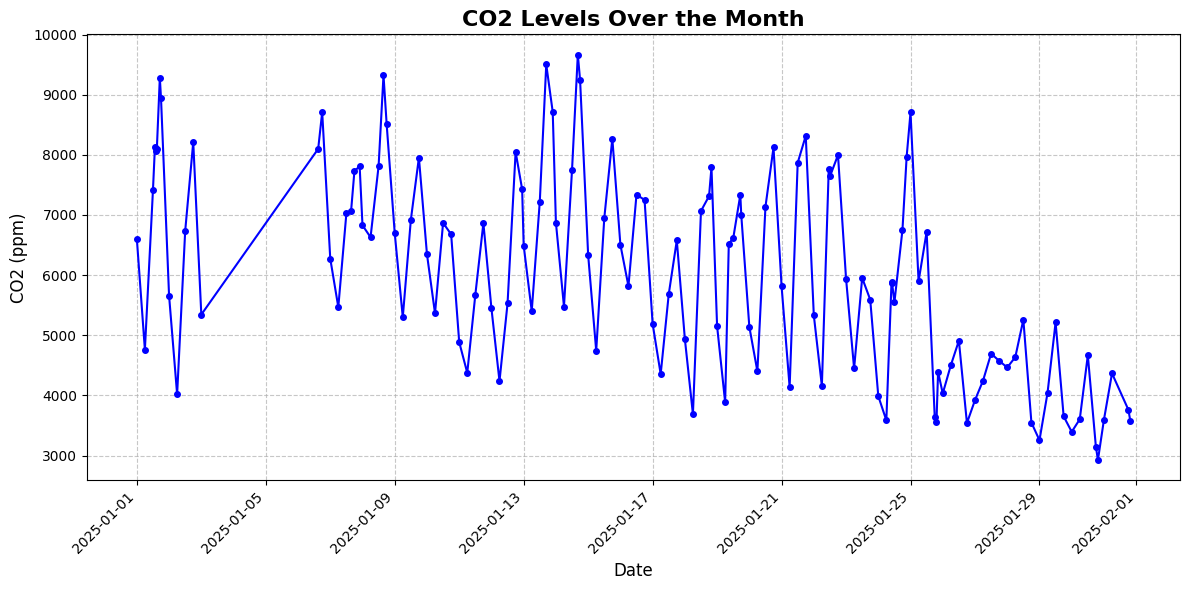

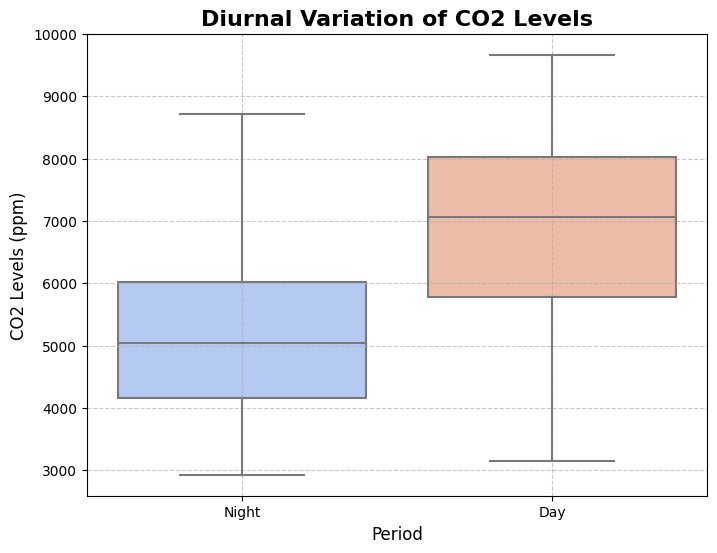

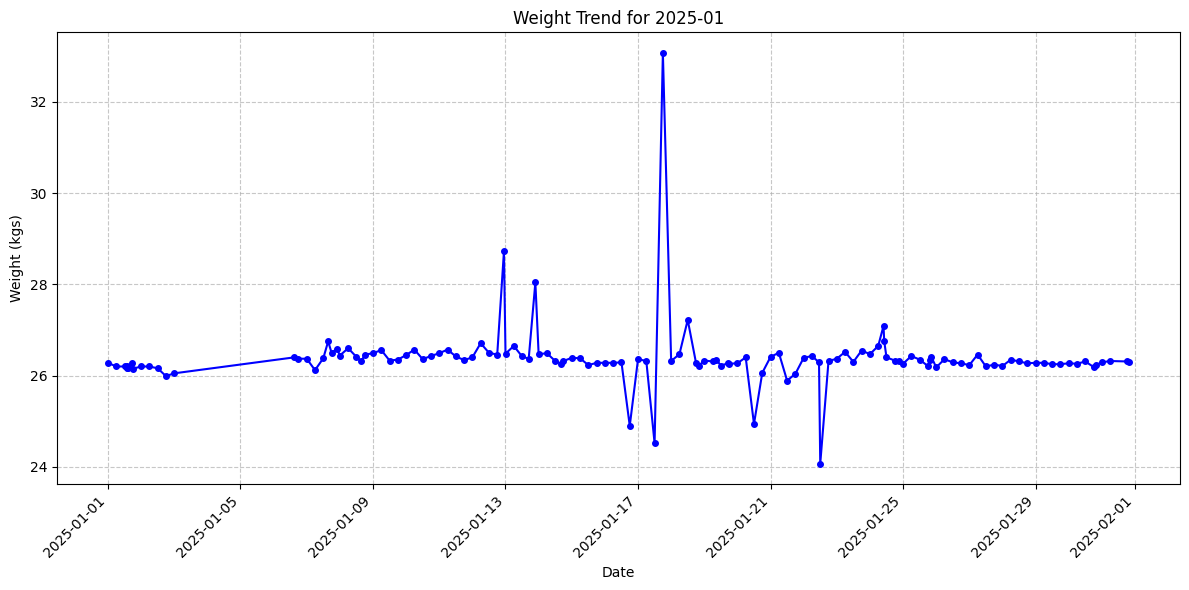

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


<Figure size 1200x600 with 0 Axes>

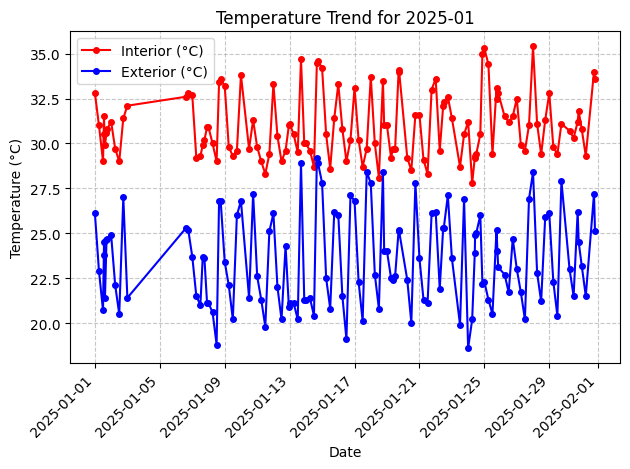

<Figure size 1000x600 with 0 Axes>

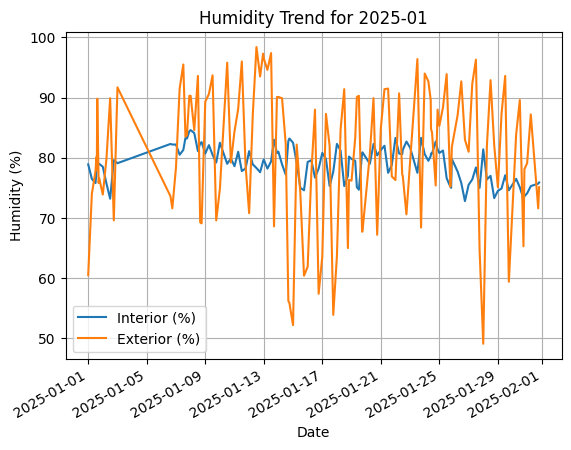

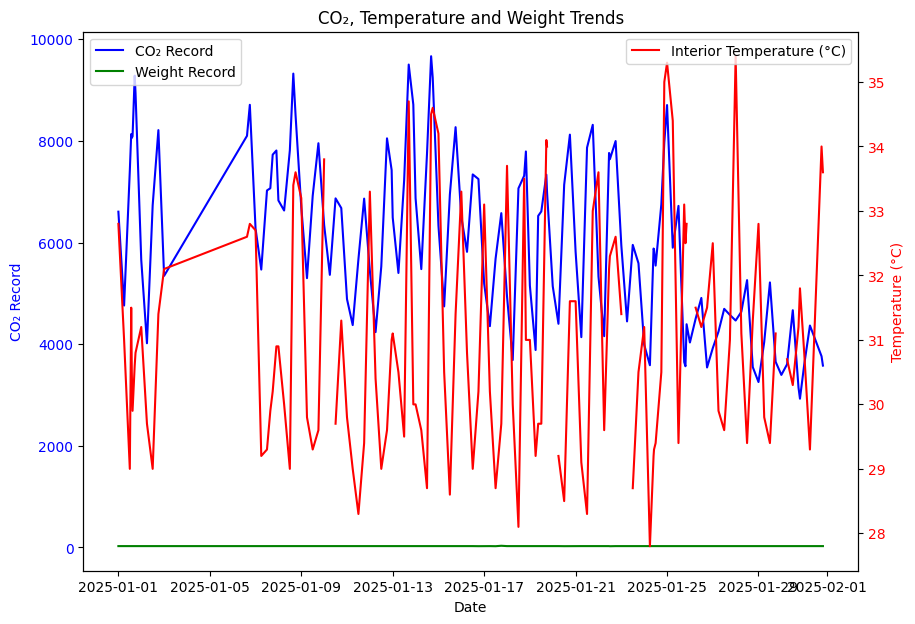

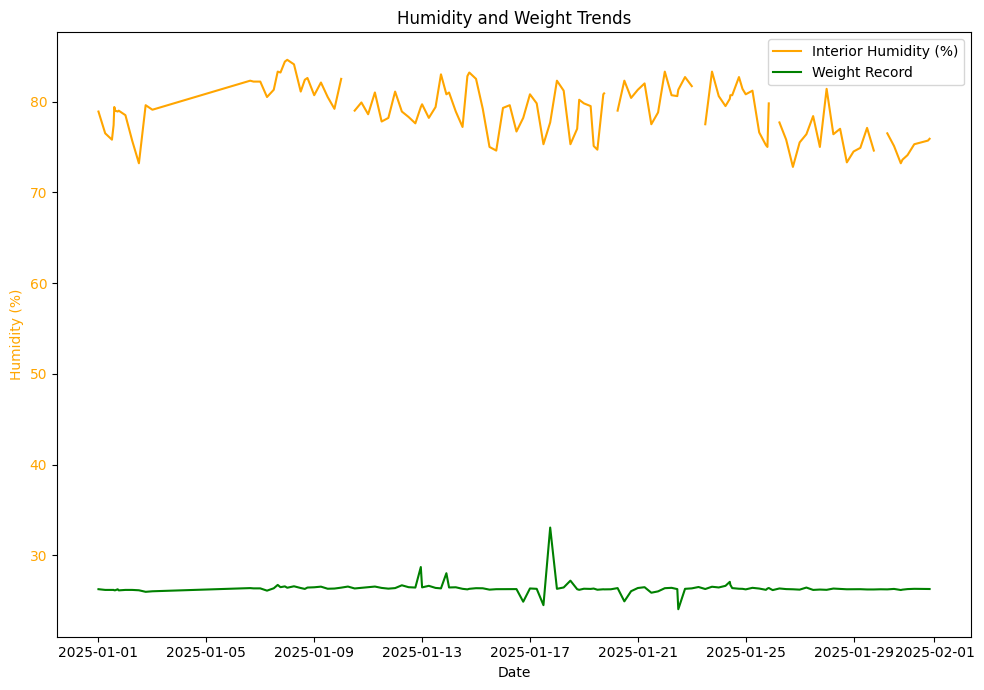

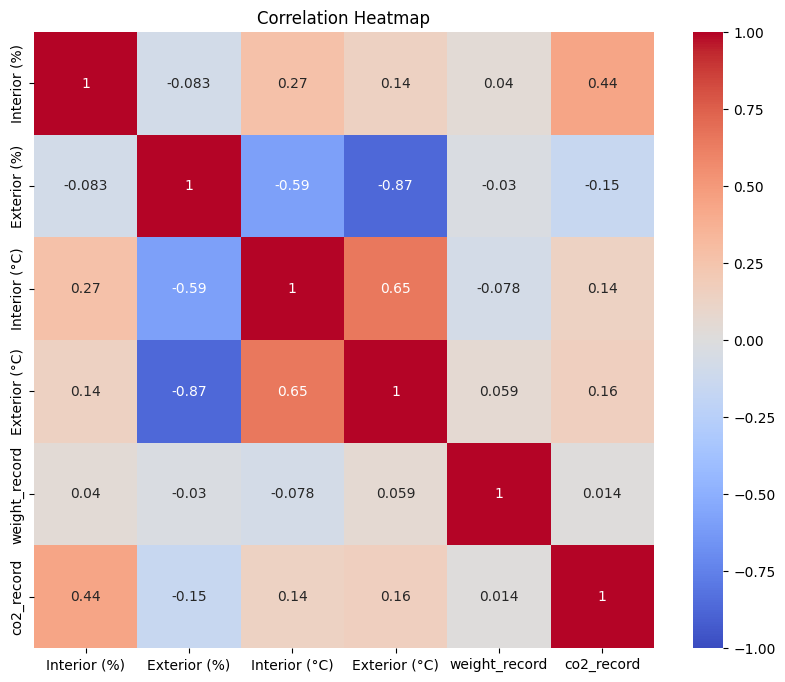

PDF generated successfully. Click the link below to download:


/kaggle/working/Monthly_Report_2025_01.pdf

In [35]:
def main(df_co2, df_weight, df_temperature, df_humidity, year, month):
    # Execute pipelines
    co2_results = analyze_co2_pipeline(df_co2, year, month)
    weight_results = analyze_weight_for_month_year(df_weight, year, month)
    temperature_results = analyze_temperature_for_month_year(df_temperature, year, month)
    humidity_results = analyze_humidity_for_month_year(df_humidity, df_weight, df_temperature, year, month)
    correlation_results = analyze_correlations(df_humidity, df_temperature, df_weight, df_co2, year, month)

    # Collect results
    results = {
        "CO2 Analysis": co2_results,
        "Weight Analysis": weight_results,
        "Temperature Analysis": temperature_results,
        "Humidity Analysis": humidity_results,
        "Correlation Analysis": correlation_results
    }

    # Collect plots
    plots = {
        "CO₂ Analysis": ["co2_monthly_trend.png", "co2_diurnal_variation.png"],
        "Weight Analysis": ["weight_monthly_trend.png"],
        "Temperature Analysis": ["temperature_trend.png"],
        "Humidity Analysis": ["humidity_trend.png"],
        "Correlation Analysis": ["combined_trends.png", "correlation_heatmap.png"]
    }

    # Generate PDF
    pdf_filename = generate_pdf(results, plots, year, month)
    
    # Create a download link for the PDF
    print("PDF generated successfully. Click the link below to download:")
    create_download_link(pdf_filename)

# Example usage
if __name__ == "__main__":
    year = 2025
    month = 1
    main(carbondioxide, weights, temperatures, humidity, year, month)